In [6]:
import torch
import os
import pandas as pd
import numpy as np
from utils.config import config_dataset
from utils.helper import ObjectView
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from utils.utils_NFs import *
from models import *

# Set the torch seed for result reproducibility
torch_seed = 3307
torch.manual_seed(torch_seed)

In [7]:

indices = []
non_null_indexes = list(np.delete(np.asarray([i for i in range(96)]), indices))
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

X_train = torch.load("../data/Pecan Street Smart Meter Data (large) (tensor)/X_train.pt")
X_test = torch.load("../data/Pecan Street Smart Meter Data (large) (tensor)/X_test.pt")
cond_train = torch.load("../data/Pecan Street Smart Meter Data (large) (tensor)/cond_train.pt")
cond_test = torch.load("../data/Pecan Street Smart Meter Data (large) (tensor)/cond_test.pt")
PV_base_train = torch.load("../data/Pecan Street Smart Meter Data (large) (tensor)/PV_base_train.pt")
PV_base_test = torch.load("../data/Pecan Street Smart Meter Data (large) (tensor)/PV_base_test.pt")

print(X_train.shape)
print(X_test.shape)
print(cond_train.shape)
print(cond_test.shape)
print(PV_base_train.shape)
print(PV_base_test.shape)

X_train = (X_train + 1) / 2
X_test = (X_test + 1) / 2
X_train, X_val, cond_train, cond_val = train_test_split(X_train, cond_train, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, cond_train.shape, cond_test.shape, X_val.shape, cond_val.shape

y_LS_scaler = StandardScaler()
y_LS_scaler.fit(X_train)
y_LS_scaled = y_LS_scaler.transform(X_train)
y_VS_scaled = y_LS_scaler.transform(X_val)
y_TEST_scaled = y_LS_scaler.transform(X_test)

x_LS_scaler = StandardScaler()
x_LS_scaler.fit(cond_train)
x_LS_scaled = x_LS_scaler.transform(cond_train)
x_VS_scaled = x_LS_scaler.transform(cond_val)
x_TEST_scaled = x_LS_scaler.transform(cond_test)

torch.Size([8760, 96])
torch.Size([2190, 96])
torch.Size([8760, 79])
torch.Size([2190, 79])
torch.Size([8760, 7, 96])
torch.Size([2190, 7, 96])


In [8]:
# n_s = 100
n_s = 20
N_q = 96

nb_epoch = 100
cf_UMNN_M = {
    'name': 'UMNN_M_1',
    'nb_steps': 1,
    'nb_layers': 4,
    'nb_neurons': 300,
    'out_size': 20,
    'weight_decay': 5e-4,
    'learning_rate': 1e-4,
    'conditioner_type': 'AutoregressiveConditioner',
    'normalizer_type': 'MonotonicNormalizer',
}

cf_AN_M = {
    'name': 'AN_M_1',
    'nb_steps': 5,
    'nb_layers': 5,
    'nb_neurons': 300,
    'out_size': 2,
    'weight_decay': 1e-3,
    'learning_rate': 1e-4,
    'conditioner_type': 'AutoregressiveConditioner',
    'normalizer_type': 'AffineNormalizer',
}
print('UMNN-M nb_steps %s nb_layers %s nb_neurons %s out_size %s weight_decay %.4e lr %.4e' % (cf_UMNN_M['nb_steps'], cf_UMNN_M['nb_layers'], cf_UMNN_M['nb_neurons'], cf_UMNN_M['out_size'], cf_UMNN_M['weight_decay'], cf_UMNN_M['learning_rate']))
print('AN-M   nb_steps %s nb_layers %s nb_neurons %s out_size %s weight_decay %.4e lr %.4e' % (cf_AN_M['nb_steps'], cf_AN_M['nb_layers'], cf_AN_M['nb_neurons'], cf_AN_M['out_size'], cf_AN_M['weight_decay'], cf_AN_M['learning_rate']))

UMNN-M nb_steps 1 nb_layers 4 nb_neurons 300 out_size 20 weight_decay 5.0000e-04 lr 1.0000e-04
AN-M   nb_steps 5 nb_layers 5 nb_neurons 300 out_size 2 weight_decay 1.0000e-03 lr 1.0000e-04


In [ ]:
config = cf_UMNN_M # cf_UMNN_M
tag = "load"

if config['normalizer_type'] == 'AffineNormalizer':
    config['conditioner_args'] = {"in_size": y_LS_scaled.shape[1],
                                    "hidden": [config['nb_neurons']] * config['nb_layers'], "out_size": 2,
                                    "cond_in": x_LS_scaled.shape[1]}
    normalizer_type = AffineNormalizer
    config['normalizer_args'] = {}

elif config['normalizer_type'] == 'MonotonicNormalizer':
    config['conditioner_args'] = {"in_size": y_LS_scaled.shape[1],
                                    "hidden": [config['nb_neurons']] * config['nb_layers'],
                                    "out_size": config['out_size'], "cond_in": x_LS_scaled.shape[1]}
    normalizer_type = MonotonicNormalizer
    config['normalizer_args'] = {
        'integrand_net': [config['out_size'] * 2, config['out_size'] * 2, config['out_size'] * 2],
        'cond_size': config['out_size'], 'nb_steps': 50, 'solver': "CCParallel", 'hot_encoding': True}

config['Adam_args'] = {"lr": config['learning_rate'], "weight_decay": config['weight_decay']}

nfs = buildFCNormalizingFlow(nb_steps=config['nb_steps'], conditioner_type=AutoregressiveConditioner,
                                conditioner_args=config['conditioner_args'], normalizer_type=normalizer_type,
                                normalizer_args=config['normalizer_args'])
opt = torch.optim.Adam(nfs.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

# --------------------------------------------------------------------------------------------------------------
# Fit the NFs
# --------------------------------------------------------------------------------------------------------------
print('Fit NFs with %s epochs' % (nb_epoch))
training_time = 0.
start = timer()
loss, best_flow, last_flow = fit_NF(nb_epoch=nb_epoch, x_LS=x_LS_scaled, y_LS=y_LS_scaled, x_VS=x_VS_scaled,
                                    y_VS=y_VS_scaled, x_TEST=x_TEST_scaled, y_TEST=y_TEST_scaled,
                                    flow=nfs,
                                    opt=opt, gpu=True)

end = timer()
training_time += end - start
print('Training time %.2f s' % (training_time))
epoch_min = np.nanargmin(loss[:, 1])
print('epoch %s ll VS is min = %.2f ll TEST = %.2f' % (epoch_min, loss[epoch_min, 1], loss[epoch_min, 2]))



Fit NFs with 100 epochs


/Users/cybsbbbb/anaconda3/envs/diff_load/lib/python3.10/site-packages/UMNN/ParallelNeuralIntegral.py:22: RuntimeWarning: divide by zero encountered in matmul
  cc_weights = torch.tensor(lam.T @ W).float()
/Users/cybsbbbb/anaconda3/envs/diff_load/lib/python3.10/site-packages/UMNN/ParallelNeuralIntegral.py:22: RuntimeWarning: overflow encountered in matmul
  cc_weights = torch.tensor(lam.T @ W).float()
/Users/cybsbbbb/anaconda3/envs/diff_load/lib/python3.10/site-packages/UMNN/ParallelNeuralIntegral.py:22: RuntimeWarning: invalid value encountered in matmul
  cc_weights = torch.tensor(lam.T @ W).float()


In [17]:
max_power = 1
# Scenarios are generated into a dict of length nb days (#VS or # TEST sizes)
# Each day of the dict is an array of shape (n_scenarios, 24)
generation_time = 0.
start = timer()
s_TEST = build_nfs_scenarios(n_s=n_s, x=x_TEST_scaled,
                                y_scaler=y_LS_scaler, flow=best_flow,
                                conditioner_args=config['conditioner_args'], max=max_power, gpu=True, tag=tag, non_null_indexes=non_null_indexes)
s_VS = build_nfs_scenarios(n_s=n_s, x=x_VS_scaled,
                            y_scaler=y_LS_scaler, flow=best_flow,
                            conditioner_args=config['conditioner_args'], max=max_power, gpu=True, tag=tag, non_null_indexes=non_null_indexes)


Scenario generation time_tot 9.9 min00000 min
Scenario generation time_tot 3.2 min0000 min


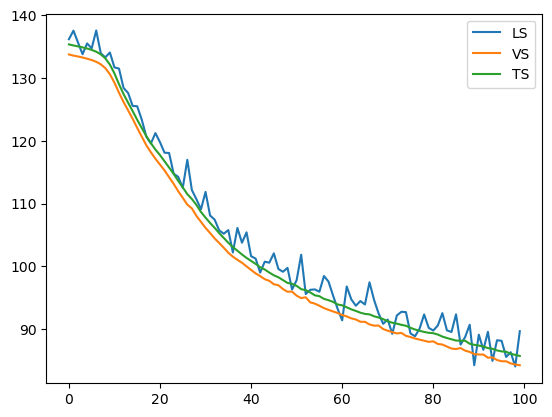

In [18]:
plt.figure()
plt.plot(loss[:, 0], label='LS')
plt.plot(loss[:, 1], label='VS')
plt.plot(loss[:, 2], label='TS')
plt.legend()

In [19]:
X_test_hat = s_TEST.reshape(-1, 96, s_TEST.shape[-1])
X_test_hat = torch.tensor(X_test_hat).permute(0, 2, 1)

In [20]:
X_test_hat = X_test_hat * 2 - 1
X_test = X_test * 2 - 1
print(X_test_hat.shape)

torch.Size([2190, 20, 96])


In [21]:
num_class = config_dataset["num_class"]

def denorm(x):
    loads = torch.load("../data/Pecan Street Smart Meter Data (large) (tensor)/loads_raw.pt")
    lmin = []
    lmax = []
    for i in range(loads.shape[0]):
        load = loads[i]
        lmin.append(load.min())
        lmax.append(load.max())
    lmin = torch.stack(lmin)[:num_class]
    lmax = torch.stack(lmax)[:num_class]
    lmin = lmin.unsqueeze(1).repeat(1, int(x.shape[0]/num_class))
    lmax = lmax.unsqueeze(1).repeat(1, int(x.shape[0]/num_class))
    lmin = lmin.reshape((-1, 1, 1))
    lmax = lmax.reshape((-1, 1, 1))
    return (x + 1) * (lmax - lmin) / 2 + lmin

In [22]:
torch.save(denorm(X_test_hat), "../result/data/pecan/load_hat_nf.pt")

/tmp/ipykernel_54140/3225336333.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loads = torch.load("./data/loads_raw.pt")


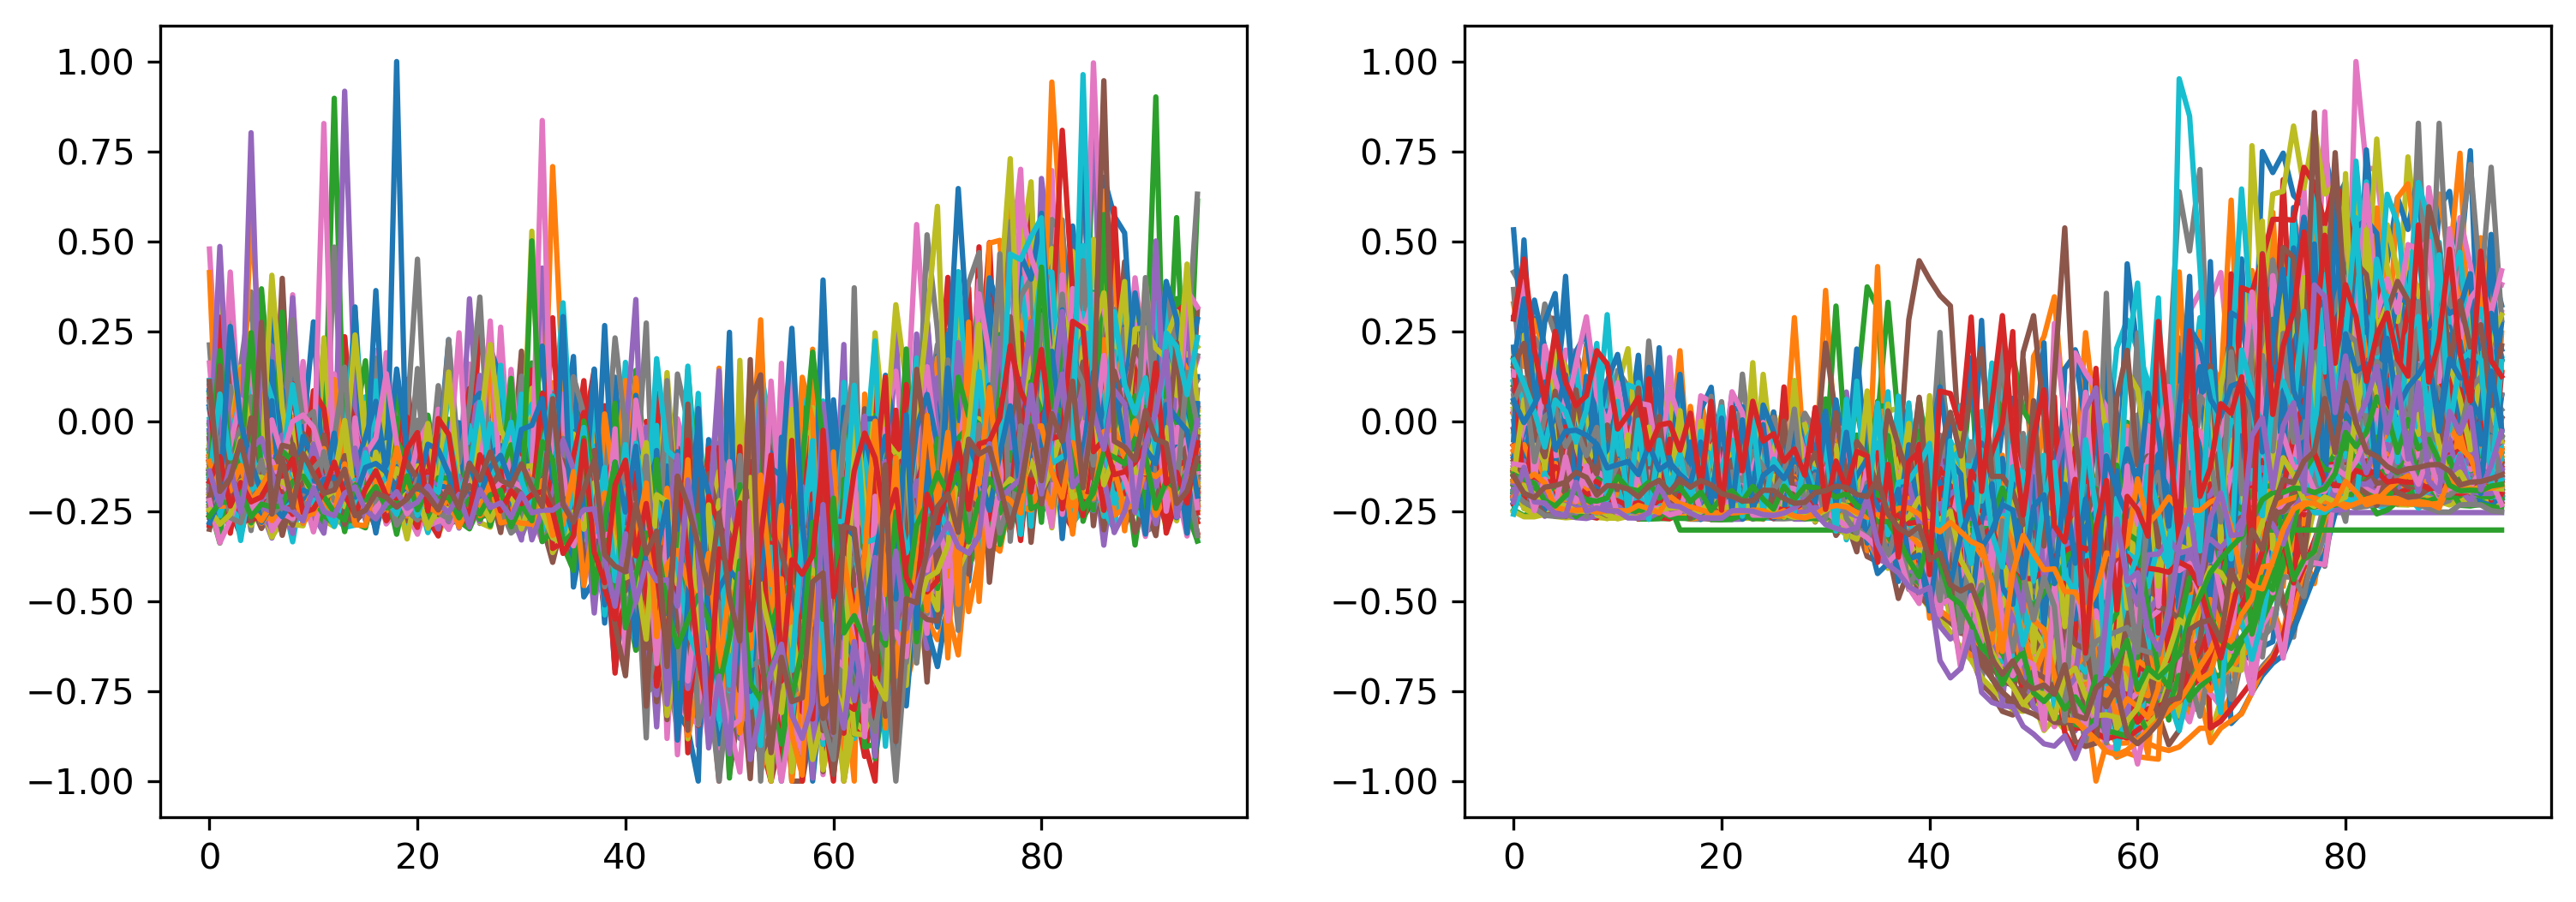

In [23]:
user = 0
plt.figure(figsize=(12,4), dpi=300)
plt.subplot(1,2,1)
for i in range(146*user, 146*(user+1)):
    plt.plot(X_test_hat[i, 0, :])
plt.subplot(1,2,2)
for i in range(146*user, 146*(user+1)):
    plt.plot(X_test[i])

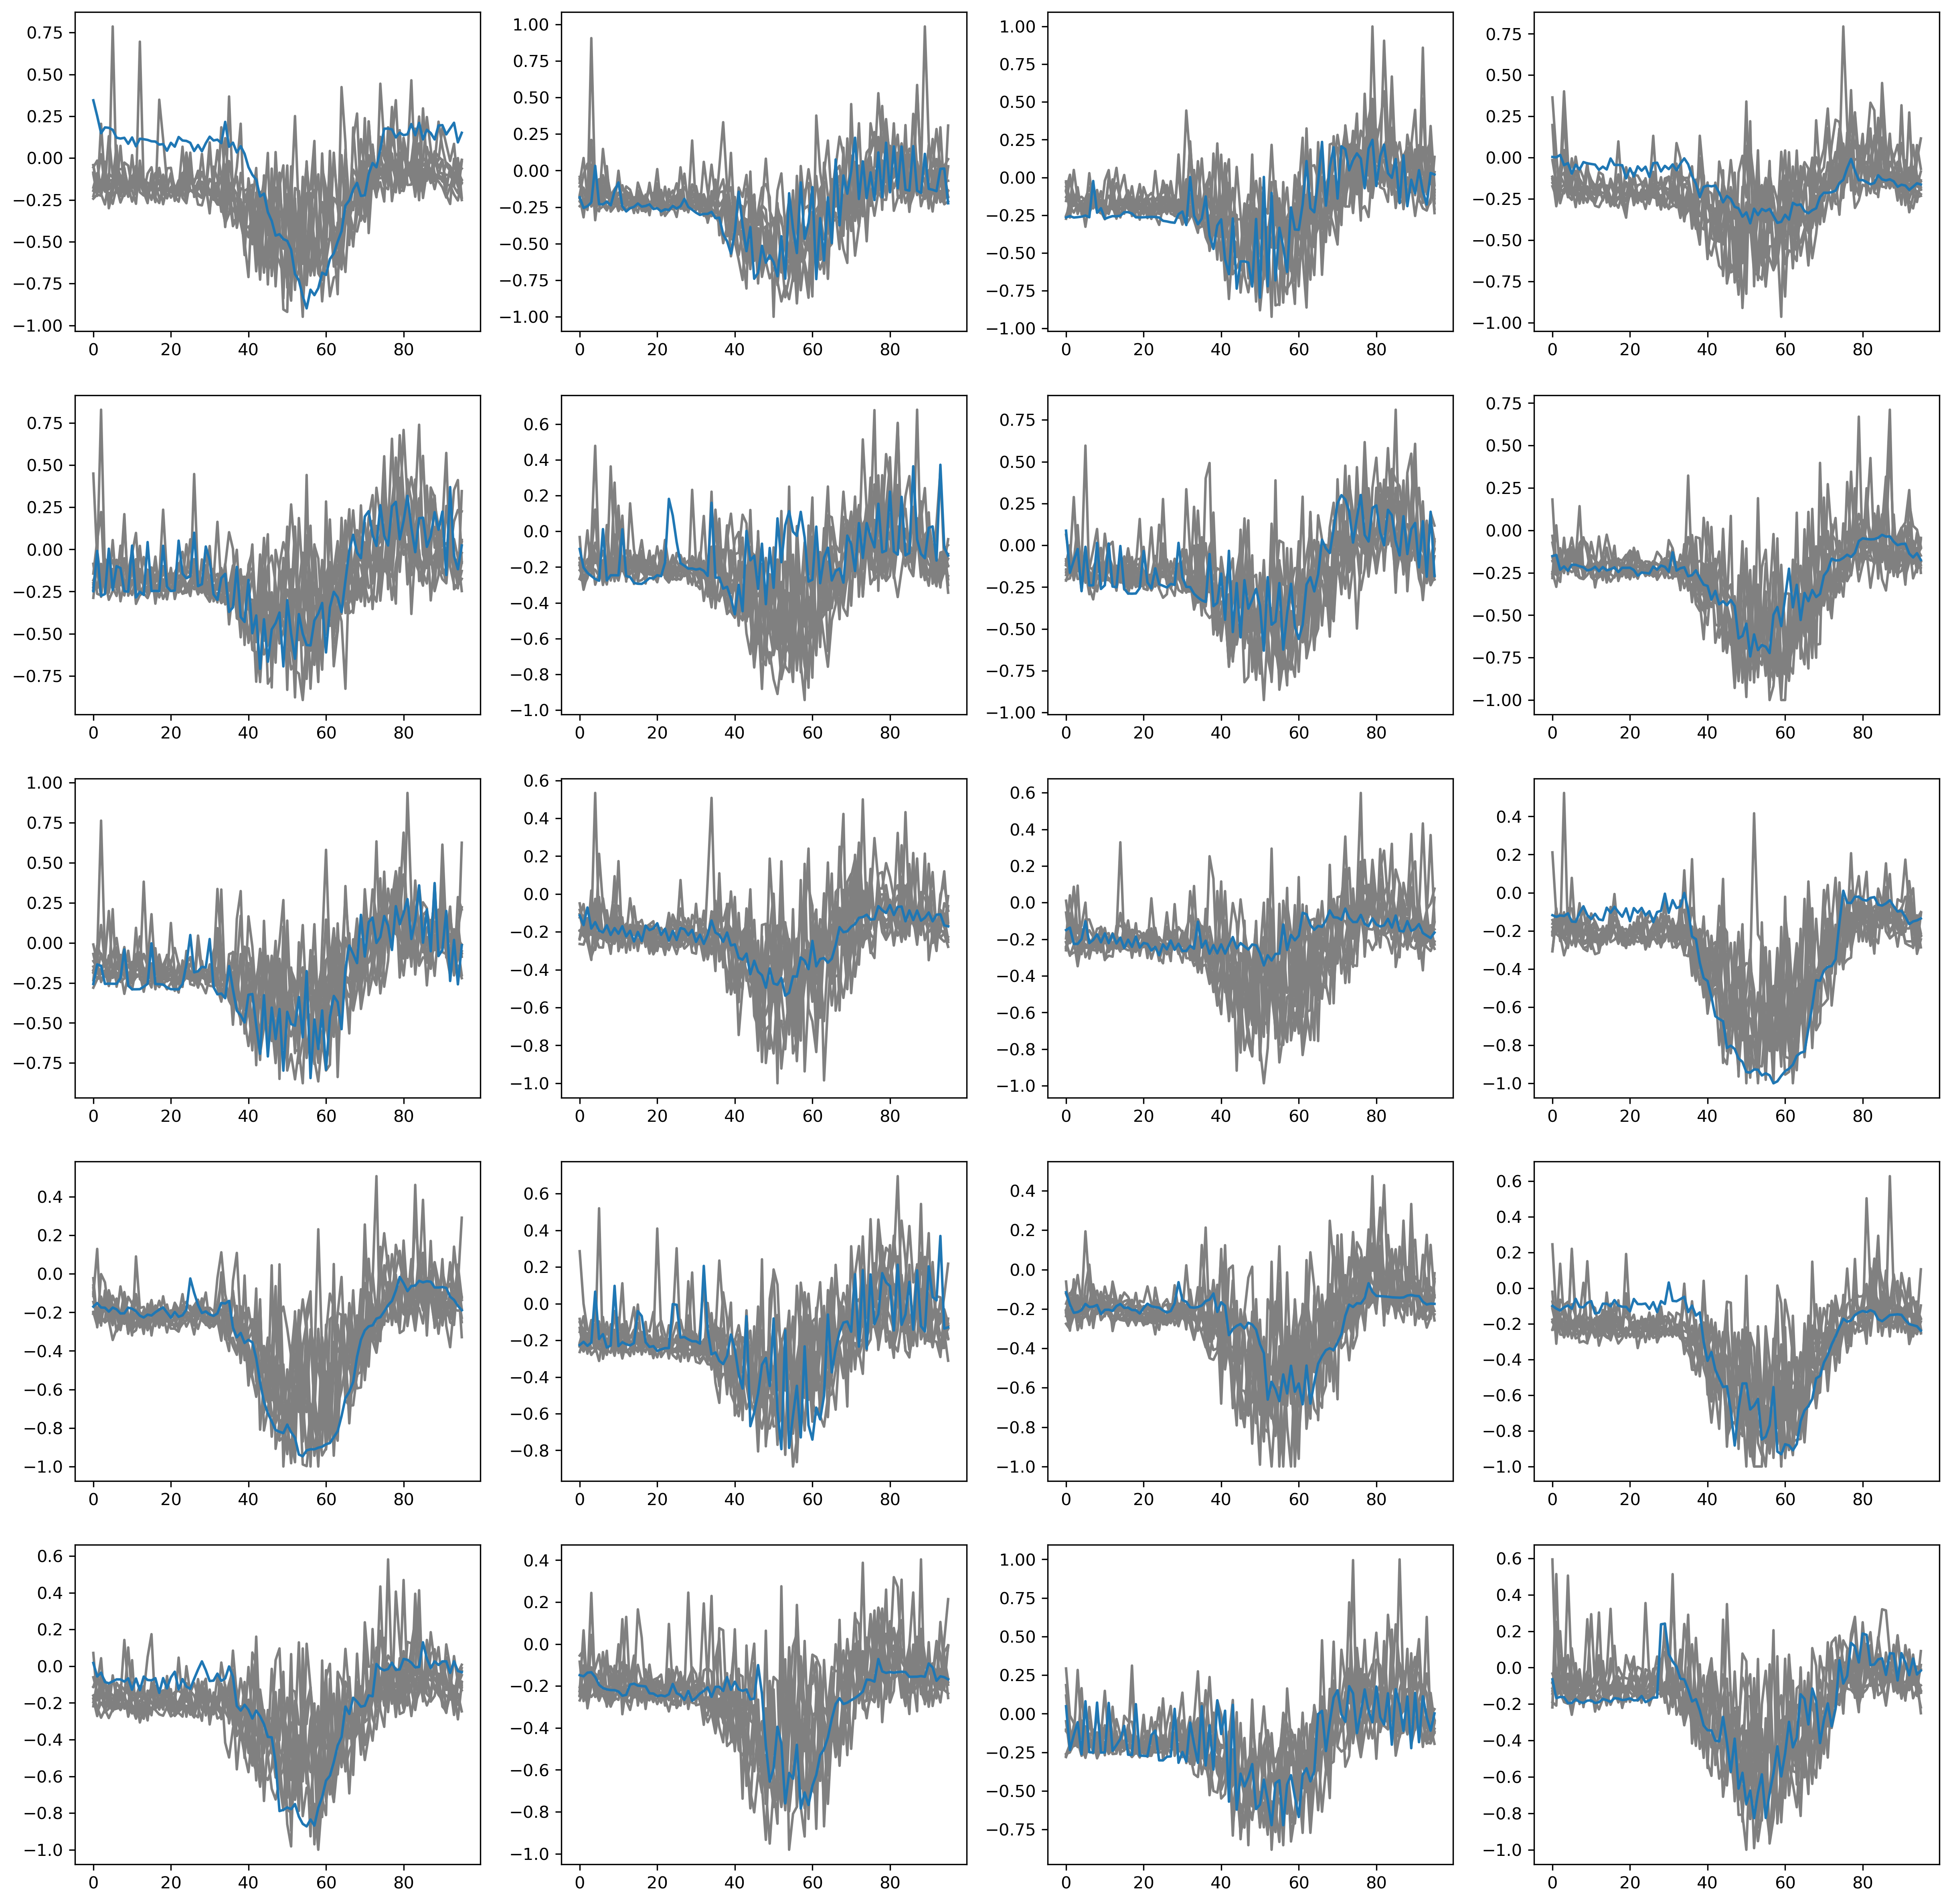

In [24]:
n = 20
plt.figure(figsize=(20,20), dpi=300)
for j in range(n):
    plt.subplot(int(n/4), 4, j+1)
    j = j + 200
    for i in range(10):
        plt.plot(X_test_hat[j][i], color='gray')
    plt.plot(X_test[j])